In [1]:
import pandas as pd
import seaborn as sns
import requests
import kaggle
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
pd.set_option('display.max_columns', 500)

How do I download using requests / API? <br>
https://github.com/Kaggle/kaggle-api <br>
kaggle datasets download -d christophercorrea/dc-residential-properties 

In [2]:
#how do I not write the entire file path?
data = pd.read_csv('/Users/Julia/dc-residential-properties/DC_Properties.csv', low_memory=False)
print(data.shape)
print(data.columns.tolist())
data.head(10)

(158957, 49)
['Unnamed: 0', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'PRICE', 'QUALIFIED', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA', 'GIS_LAST_MOD_DTTM', 'SOURCE', 'CMPLX_NUM', 'LIVING_GBA', 'FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID', 'LATITUDE', 'LONGITUDE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT', 'CENSUS_BLOCK', 'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT']


,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,3.0,2003-11-25 00:00:00,1095000.0,Q,1,2522.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,2.0,5,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1748 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23061 09289,38.914680,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,1972,3.0,2000-08-17 00:00:00,NaN,U,1,2567.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1746 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23067 09289,38.914683,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,3.0,2016-06-21 00:00:00,2100000.0,Q,3,2522.0,1,3 Story,Row Inside,Very Good,Very Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1744 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23074 09289,38.914684,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,3.0,2006-07-12 00:00:00,1602000.0,Q,1,2484.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,3,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1742 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23078 09288,38.914683,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,1985,3.0,NaN,NaN,U,1,5255.0,1,3 Story,Semi-Detached,Very Good,Good,Common Brick,Neopren,Hardwood,1.0,0,13,2032,2018-07-22 18:01:43,Residential,NaN,NaN,1804 NEW HAMPSHIRE AVENUE NW,WASHINGTON,DC,20009.0,18S UJ 23188 09253,38.914383,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
5,5,3,2,Hot Water Rad,Y,1.0,10,5,1913.0,NaN,1972,4.0,2010-02-26 00:00:00,1950000.0,Q,1,5344.0,1,4 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,1.0,4,11,2196,2018-07-22 18:01:43,Residential,NaN,NaN,1709 S STREET NW,WASHINGTON,DC,20009.0,18S UJ 23157 09248,38.914331,-77.039715,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
6,6,1,0,Warm Cool,Y,2.0,5,2,1917.0,1988.0,1957,2.0,2011-05-02 00:00:00,NaN,U,1,1260.0,1,2 Story,Row Inside,Above Average,Average,Common Brick,Metal- Sms,Hardwood,2.0,0,24,1261,2018-07-22 18:01:43,Residential,NaN,NaN,1769 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23042 09323,38.914983,-77.041055,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW
7,7,3,1,Hot Water Rad,Y,2.0,8,4,1906.0,2011.0,1972,3.0,2011-09-29 00:00:00,1050000.0,Q,1,2401.0,1,3 Story,Row Inside,Very Good,Average,Common Brick,Metal- Sms,Hardwood,2.0,1,24,1627,2018-07-22 18:01:43,Residential,NaN,NaN,1746 1/2 T STREET NW,WASHINGTON,DC,20009.0,18S UJ 23124 09368,38.915408,-77.040129,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW
8,8,3,1,Warm Cool,Y,2.0,7,3,1908.0,2008.0,1967,2.0,2018-05-03 00:00:00,1430000.0,Q,4,1488.0,1,2 Story,Row Inside,Above Average,Very Good,Common Brick,Built Up,Hardwood,2.0,1,24,1424,2018-07-22 18:01:43,Residential,NaN,NaN,1727 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23142 09324,38.915017,-77.039903,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW
9,9,1,1,Hot Water Rad,Y,1.0,6,2,1908.0,1979.0,1950,2.0,2008-12-05 00:00:00,NaN,U,1,1590.0,1,2 Story,Row Inside,Good Quality,Average,Common Brick,Built Up,Hardwood,

In [3]:
ddat = pd.DataFrame.drop(data, columns = 'Unnamed: 0')

In [4]:
#combine BR columns
ddat['BATHRMS'] = ddat['BATHRM'] + ddat['HF_BATHRM']
ddat = pd.DataFrame.drop(ddat, columns = ['BATHRM', 'HF_BATHRM'])

In [5]:
#percentages of NaN values per column
perc_nan=(ddat.isnull().sum(axis = 0))/len(ddat)
#delete NaN rows from columns with few NaN values:
dlist = (perc_nan[perc_nan <= 0.02].index).tolist()
print(dlist)
ddat = ddat.dropna(subset=dlist)

['HEAT', 'AC', 'ROOMS', 'BEDRM', 'AYB', 'EYB', 'QUALIFIED', 'SALE_NUM', 'BLDG_NUM', 'FIREPLACES', 'USECODE', 'LANDAREA', 'GIS_LAST_MOD_DTTM', 'SOURCE', 'ZIPCODE', 'LATITUDE', 'LONGITUDE', 'ASSESSMENT_NBHD', 'CENSUS_TRACT', 'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT', 'BATHRMS']


In [6]:
#evaluate rows with more NaN values
print(perc_nan[perc_nan > 0.02])

NUM_UNITS             0.328774
YR_RMDL               0.490881
STORIES               0.329051
SALEDATE              0.168410
PRICE                 0.382122
GBA                   0.328774
STYLE                 0.328774
STRUCT                0.328774
GRADE                 0.328774
CNDTN                 0.328774
EXTWALL               0.328774
ROOF                  0.328774
INTWALL               0.328774
KITCHENS              0.328781
CMPLX_NUM             0.671226
LIVING_GBA            0.671226
FULLADDRESS           0.332901
CITY                  0.332832
STATE                 0.332832
NATIONALGRID          0.332832
ASSESSMENT_SUBNBHD    0.204779
CENSUS_BLOCK          0.332832
dtype: float64


In [7]:
#Are values the same for CITY and STATE?
print(data.CITY.value_counts())
print(data.STATE.value_counts())

WASHINGTON    106051
Name: CITY, dtype: int64
DC    106051
Name: STATE, dtype: int64


In [8]:
ddat = pd.DataFrame.drop(ddat, columns=['CMPLX_NUM', 'STATE', 'CITY', 'FULLADDRESS', 'NATIONALGRID'])
print(ddat.shape)
print(ddat.columns.tolist())
ddat.head(10)


(158449, 42)
['HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'PRICE', 'QUALIFIED', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA', 'GIS_LAST_MOD_DTTM', 'SOURCE', 'LIVING_GBA', 'ZIPCODE', 'LATITUDE', 'LONGITUDE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT', 'CENSUS_BLOCK', 'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT', 'BATHRMS']


,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,LIVING_GBA,ZIPCODE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,BATHRMS
0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,3.0,2003-11-25 00:00:00,1095000.0,Q,1,2522.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,2.0,5,24,1680,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914680,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW,4
1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,1972,3.0,2000-08-17 00:00:00,NaN,U,1,2567.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914683,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW,4
2,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,3.0,2016-06-21 00:00:00,2100000.0,Q,3,2522.0,1,3 Story,Row Inside,Very Good,Very Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914684,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW,4
3,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,3.0,2006-07-12 00:00:00,1602000.0,Q,1,2484.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,3,24,1680,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914683,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW,4
4,Warm Cool,Y,1.0,11,3,1913.0,2012.0,1985,3.0,NaN,NaN,U,1,5255.0,1,3 Story,Semi-Detached,Very Good,Good,Common Brick,Neopren,Hardwood,1.0,0,13,2032,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914383,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW,3
5,Hot Water Rad,Y,1.0,10,5,1913.0,NaN,1972,4.0,2010-02-26 00:00:00,1950000.0,Q,1,5344.0,1,4 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,1.0,4,11,2196,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914331,-77.039715,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW,5
6,Warm Cool,Y,2.0,5,2,1917.0,1988.0,1957,2.0,2011-05-02 00:00:00,NaN,U,1,1260.0,1,2 Story,Row Inside,Above Average,Average,Common Brick,Metal- Sms,Hardwood,2.0,0,24,1261,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914983,-77.041055,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW,1
7,Hot Water Rad,Y,2.0,8,4,1906.0,2011.0,1972,3.0,2011-09-29 00:00:00,1050000.0,Q,1,2401.0,1,3 Story,Row Inside,Very Good,Average,Common Brick,Metal- Sms,Hardwood,2.0,1,24,1627,2018-07-22 18:01:43,Residential,NaN,20009.0,38.915408,-77.040129,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW,4
8,Warm Cool,Y,2.0,7,3,1908.0,2008.0,1967,2.0,2018-05-03 00:00:00,1430000.0,Q,4,1488.0,1,2 Story,Row Inside,Above Average,Very Good,Common Brick,Built Up,Hardwood,2.0,1,24,1424,2018-07-22 18:01:43,Residential,NaN,20009.0,38.915017,-77.039903,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW,4
9,Hot Water Rad,Y,1.0,6,2,1908.0,1979.0,1950,2.0,2008-12-05 00:00:00,NaN,U,1,1590.0,1,2 Story,Row Inside,Good Quality,Average,Common Brick,Built Up,Hardwood,1.0,0,11,1424,2018-07-22 18:01:43,Residential,NaN,20009.0,38.915015,-77.040081,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW,2


In [9]:
#We will make a small dataset, which contains no null values from price. 
sdat = ddat.dropna(subset=['PRICE'])
print(sdat.shape)
sdat.head(10)

(98003, 42)


,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,LIVING_GBA,ZIPCODE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,BATHRMS
0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,3.0,2003-11-25 00:00:00,1095000.0,Q,1,2522.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,2.0,5,24,1680,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914680,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW,4
2,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,3.0,2016-06-21 00:00:00,2100000.0,Q,3,2522.0,1,3 Story,Row Inside,Very Good,Very Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914684,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW,4
3,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,3.0,2006-07-12 00:00:00,1602000.0,Q,1,2484.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,3,24,1680,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914683,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW,4
5,Hot Water Rad,Y,1.0,10,5,1913.0,NaN,1972,4.0,2010-02-26 00:00:00,1950000.0,Q,1,5344.0,1,4 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,1.0,4,11,2196,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914331,-77.039715,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW,5
7,Hot Water Rad,Y,2.0,8,4,1906.0,2011.0,1972,3.0,2011-09-29 00:00:00,1050000.0,Q,1,2401.0,1,3 Story,Row Inside,Very Good,Average,Common Brick,Metal- Sms,Hardwood,2.0,1,24,1627,2018-07-22 18:01:43,Residential,NaN,20009.0,38.915408,-77.040129,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW,4
8,Warm Cool,Y,2.0,7,3,1908.0,2008.0,1967,2.0,2018-05-03 00:00:00,1430000.0,Q,4,1488.0,1,2 Story,Row Inside,Above Average,Very Good,Common Brick,Built Up,Hardwood,2.0,1,24,1424,2018-07-22 18:01:43,Residential,NaN,20009.0,38.915017,-77.039903,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW,4
14,Warm Cool,Y,2.0,5,3,1917.0,2000.0,1967,2.0,2011-09-30 00:00:00,1325000.0,Q,1,2692.0,1,2 Story,Row Inside,Above Average,Very Good,Stucco,Metal- Sms,Hardwood,2.0,1,24,1815,2018-07-22 18:01:43,Residential,NaN,20009.0,38.915038,-77.039716,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW,4
16,Warm Cool,Y,1.0,8,3,1908.0,2006.0,1967,2.0,2010-11-04 00:00:00,1240000.0,Q,1,1662.0,1,2 Story,Row Inside,Above Average,Very Good,Common Brick,Metal- Sms,Hardwood,1.0,0,11,1424,2018-07-22 18:01:43,Residential,NaN,20009.0,38.915018,-77.039844,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW,4
19,Hot Water Rad,Y,2.0,9,3,1908.0,2013.0,1969,2.0,2001-07-23 00:00:00,592250.0,Q,1,1598.0,1,2 Story,Row Inside,Good Quality,Good,Common Brick,Built Up,Hardwood,2.0,1,24,1424,2018-07-22 18:01:43,Residential,NaN,20009.0,38.915019,-77.040138,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW,4
20,Hot Water Rad,Y,1.0,14,5,1880.0,2009.0,1987,3.0,2016-01-12 00:00:00,33232.0,U,3,3465.0,1,3 Story,Semi-Detached,Very Good,Very Good,Common Brick,Built Up,Hardwood,1.0,3,13,2090,2018-07-22 18:01:43,Residential,NaN,20009.0,38.911370,-77.033774,Old City 2,040 E Old City 2,5201.0,005201 4003,Ward 2,0208,-77.033366,38.911716,NW,4


In [10]:
#if we remove all NaNs, we have no data.
ldat = sdat.dropna()
ldat.head()

,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,LIVING_GBA,ZIPCODE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,BATHRMS


In [11]:
#types of data in df
sdat.dtypes

HEAT                   object
AC                     object
NUM_UNITS             float64
ROOMS                   int64
BEDRM                   int64
AYB                   float64
YR_RMDL               float64
EYB                     int64
STORIES               float64
SALEDATE               object
PRICE                 float64
QUALIFIED              object
SALE_NUM                int64
GBA                   float64
BLDG_NUM                int64
STYLE                  object
STRUCT                 object
GRADE                  object
CNDTN                  object
EXTWALL                object
ROOF                   object
INTWALL                object
KITCHENS              float64
FIREPLACES              int64
USECODE                 int64
LANDAREA                int64
GIS_LAST_MOD_DTTM      object
SOURCE                 object
LIVING_GBA            float64
ZIPCODE               float64
LATITUDE              float64
LONGITUDE             float64
ASSESSMENT_NBHD        object
ASSESSMENT

In [12]:
#TWO LISTS OF COLUMNS. ONE CATEGORICAL, ONE NUMERICAL catcol and numcol
#TWO DFS of categorical and numerical. catdf and numdf
catcol = []
numcol = []
for col in sdat.columns:
    if (sdat[col].dtype == object):
        catcol.append(col)
    if (sdat[col].dtype == np.int64) or (sdat[col].dtype == np.float64):
        numcol.append(col)
catdf = sdat[catcol].astype('category')
numdf = sdat[numcol].astype(np.float64)
print(catcol)
print(numcol)

['HEAT', 'AC', 'SALEDATE', 'QUALIFIED', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'GIS_LAST_MOD_DTTM', 'SOURCE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_BLOCK', 'WARD', 'SQUARE', 'QUADRANT']
['NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'PRICE', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA', 'LIVING_GBA', 'ZIPCODE', 'LATITUDE', 'LONGITUDE', 'CENSUS_TRACT', 'X', 'Y', 'BATHRMS']


In [13]:
#show information about values, outlier counts, and fences per numerical variable
def show_outliers(df_in, col):
    q1 = df_in[col].quantile(0.25)
    q3 = df_in[col].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col] < fence_low) | (df_in[col] > fence_high)]
    print(col)
    print("fence_low:", fence_low) 
    print("Q1:", q1)
    print("Q3:", q3) 
    print("fence_high:", fence_high)
    print("num_outliers:", len(df_out))
    print((df_in[col].value_counts().sort_index()).head(5))
    print((df_in[col].value_counts().sort_index()).tail(5))
for col in numdf.columns:
    show_outliers(numdf, col)

NUM_UNITS
fence_low: 1.0
Q1: 1.0
Q3: 1.0
fence_high: 1.0
num_outliers: 8535
0.0       45
1.0    49169
2.0     6042
3.0      589
4.0     1852
Name: NUM_UNITS, dtype: int64
2.0    6042
3.0     589
4.0    1852
5.0       4
6.0       3
Name: NUM_UNITS, dtype: int64
ROOMS
fence_low: -0.5
Q1: 4.0
Q3: 7.0
fence_high: 11.5
num_outliers: 3709
0.0       53
1.0       63
2.0     3888
3.0    13922
4.0    15882
Name: ROOMS, dtype: int64
25.0    3
26.0    1
28.0    2
30.0    1
31.0    1
Name: ROOMS, dtype: int64
BEDRM
fence_low: 0.5
Q1: 2.0
Q3: 3.0
fence_high: 4.5
num_outliers: 10959
0.0     3809
1.0    18671
2.0    23633
3.0    30054
4.0    14686
Name: BEDRM, dtype: int64
12.0    20
13.0     1
14.0     1
15.0     1
20.0     1
Name: BEDRM, dtype: int64
AYB
fence_low: 1843.5
Q1: 1917.0
Q3: 1966.0
fence_high: 2039.5
num_outliers: 144
1754.0    1
1765.0    1
1776.0    2
1780.0    3
1790.0    3
Name: AYB, dtype: int64
2014.0    590
2015.0    834
2016.0    929
2017.0    487
2018.0     65
Name: AYB, dtype: 

In [14]:
def perc_outliers(df_in, col, slow, shigh):
    q1 = df_in[col].quantile(0.25)
    q3 = df_in[col].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-slow*iqr
    fence_high = q3+shigh*iqr
    df_out = df_in.loc[(df_in[col] < fence_low) | (df_in[col] > fence_high)]
    print("Percentage of outliers:", len(df_out)/len(df_in))

Percentage of outliers: 0.016785200453047357
None


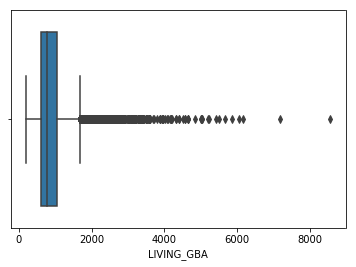

In [15]:
print(perc_outliers(sdat, 'LIVING_GBA', 1.5, 1.5))
sns.boxplot(x=sdat['LIVING_GBA'], whis=1.5)

/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


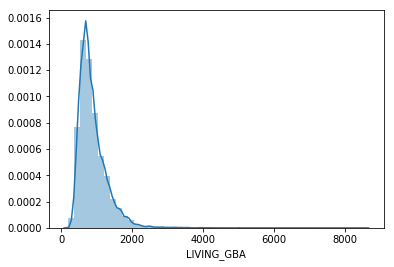

In [16]:
sns.distplot(sdat['LIVING_GBA'].dropna())

Percentage of outliers: 0.035988694223646214
None


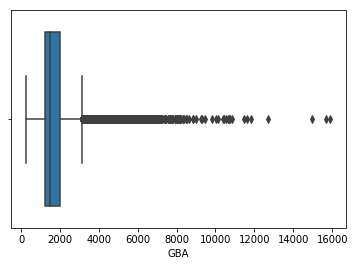

In [17]:
print(perc_outliers(sdat, 'GBA', 1.5, 1.5))
sns.boxplot(x=sdat['GBA'], whis=1.5)

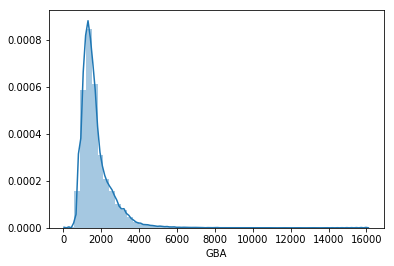

In [18]:
sns.distplot(sdat['GBA'].dropna())

Percentage of outliers: 0.029611338428415457
None


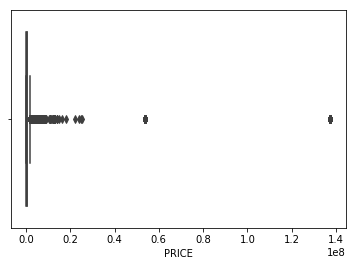

In [19]:
print(perc_outliers(sdat, 'PRICE', 1, 2.5))
sns.boxplot(x=sdat['PRICE'], whis=2.5)

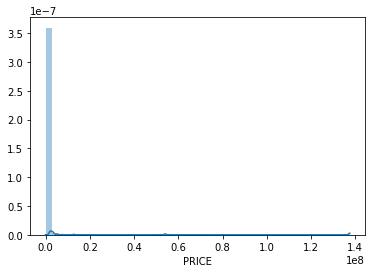

In [20]:
sns.distplot(sdat['PRICE'].dropna())

Percentage of outliers: 0.03224391090068671
None


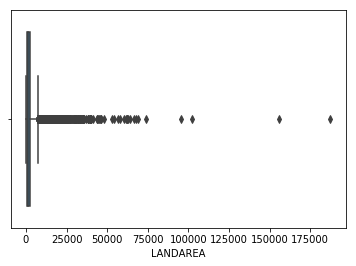

In [21]:
print(perc_outliers(sdat, 'LANDAREA', 1, 2.5))
sns.boxplot(x=sdat['LANDAREA'], whis=2.5)

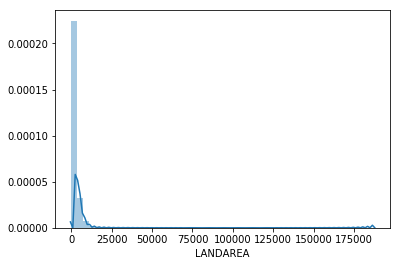

In [22]:
sns.distplot(sdat['LANDAREA'].dropna())

In [23]:
#checking values for categorical:
for col in catdf.columns:
    print(col) 
    print(catdf[col].value_counts().sort_index())

HEAT
Air Exchng           22
Air-Oil              69
Elec Base Brd       249
Electric Rad         93
Evp Cool             26
Forced Air        39333
Gravity Furnac       51
Hot Water Rad     22778
Ht Pump           16845
Ind Unit             35
No Data             209
Wall Furnace        706
Warm Cool         17315
Water Base Brd      272
Name: HEAT, dtype: int64
AC
0       37
N    18418
Y    79548
Name: AC, dtype: int64
SALEDATE
1982-06-11 00:00:00     1
1984-05-31 00:00:00     1
1984-07-20 00:00:00     1
1985-08-05 00:00:00     1
1986-06-10 00:00:00     1
1986-12-02 00:00:00     1
1988-04-13 00:00:00     1
1988-12-11 00:00:00     1
1990-05-17 00:00:00     1
1990-08-20 00:00:00     1
1990-09-29 00:00:00     1
1990-12-12 00:00:00     1
1991-03-29 00:00:00     1
1991-08-14 00:00:00     1
1991-11-29 00:00:00     1
1992-01-02 00:00:00     5
1992-01-03 00:00:00     2
1992-01-06 00:00:00     5
1992-01-07 00:00:00     4
1992-01-08 00:00:00     1
1992-01-09 00:00:00     4
1992-01-10 00:00:00 

In [24]:
#REMOVING OUTLIERS: When limiting these values, the data shrunk considerably. 
#The only data that was likely faulty (and not just out of "the norm") was
#STORIES: 250.00, 275.00, 826.00        
#YR_RMDL: 20

odat = sdat.loc[(sdat['NUM_UNITS'] >= 1) & (sdat['NUM_UNITS'] <= 4) & (sdat['ROOMS'] <= 12) & (sdat['BEDRM'] <= 6) & (sdat['YR_RMDL'] >= 1880) & 
          (sdat['STORIES'] >= 1) & (sdat['STORIES'] <= 3) & (sdat['KITCHENS'] >= 1) & (sdat['KITCHENS'] <= 4) & (sdat['FIREPLACES'] >= 1) & 
          (sdat['FIREPLACES'] <= 3) & (sdat['BATHRMS'] >= 1) & (sdat['BATHRMS'] <= 7)]

odat2 = sdat.loc[((sdat['STORIES'] < 30) | (sdat['STORIES'].isna()))  & ((sdat['YR_RMDL'] >= 1880) | (sdat['YR_RMDL'].isna()))]

print(sdat.shape)
print(odat2.shape)

(98003, 42)
(97998, 42)


In [25]:
#Removeing outliers from GBA, LIVING_GBA, LANDAREA, and PRICE
takind = []
def remove_outliers (df_in, col, slow, shigh):
    q1 = df_in[col].quantile(0.25)
    q3 = df_in[col].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-slow*iqr
    fence_high = q3+shigh*iqr
    global iout
    iout = (df_in.loc[(df_in[col] < fence_low) | (df_in[col] > fence_high)]).index.tolist()
    for i in iout:
        if i not in takind:
            takind.append(i) 
    
remove_outliers(odat2, 'GBA', 1.5, 1.5)
remove_outliers(odat2, 'LIVING_GBA', 1.5, 1.5)
remove_outliers(odat2, 'LANDAREA', 1, 2.5)
remove_outliers(odat2, 'PRICE', 1, 2.5)
print(len(takind))

8347


In [26]:
#dataframe without outliers: odatd
odatd = odat2.drop(index=takind)
print(odatd.shape)
odatd.head()

(89651, 42)


,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,LIVING_GBA,ZIPCODE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,BATHRMS
0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,3.0,2003-11-25 00:00:00,1095000.0,Q,1,2522.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,2.0,5,24,1680,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914680,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW,4
3,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,3.0,2006-07-12 00:00:00,1602000.0,Q,1,2484.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,3,24,1680,2018-07-22 18:01:43,Residential,NaN,20009.0,38.914683,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW,4
7,Hot Water Rad,Y,2.0,8,4,1906.0,2011.0,1972,3.0,2011-09-29 00:00:00,1050000.0,Q,1,2401.0,1,3 Story,Row Inside,Very Good,Average,Common Brick,Metal- Sms,Hardwood,2.0,1,24,1627,2018-07-22 18:01:43,Residential,NaN,20009.0,38.915408,-77.040129,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW,4
8,Warm Cool,Y,2.0,7,3,1908.0,2008.0,1967,2.0,2018-05-03 00:00:00,1430000.0,Q,4,1488.0,1,2 Story,Row Inside,Above Average,Very Good,Common Brick,Built Up,Hardwood,2.0,1,24,1424,2018-07-22 18:01:43,Residential,NaN,20009.0,38.915017,-77.039903,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW,4
14,Warm Cool,Y,2.0,5,3,1917.0,2000.0,1967,2.0,2011-09-30 00:00:00,1325000.0,Q,1,2692.0,1,2 Story,Row Inside,Above Average,Very Good,Stucco,Metal- Sms,Hardwood,2.0,1,24,1815,2018-07-22 18:01:43,Residential,NaN,20009.0,38.915038,-77.039716,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,0152,-77.040429,38.914881,NW,4


In [27]:
#percentage of missing data per row in new dataset
def missingdat(df):
    percnan=(df.isnull().sum(axis=0))/len(df)
    nulcolstat = percnan[percnan>0]
    nullist = (nulcolstat.index).tolist()
    nuldat = sdat[nullist]
    print(nulcolstat)
print(missingdat(odatd))

NUM_UNITS             0.422985
YR_RMDL               0.413247
STORIES               0.423264
SALEDATE              0.000011
GBA                   0.422985
STYLE                 0.422985
STRUCT                0.422985
GRADE                 0.422985
CNDTN                 0.422985
EXTWALL               0.422985
ROOF                  0.422985
INTWALL               0.422985
KITCHENS              0.422996
LIVING_GBA            0.577015
ASSESSMENT_SUBNBHD    0.195837
CENSUS_BLOCK          0.426119
dtype: float64
None


In [28]:
#create categorical and numerical dataframes
catcol = []
intcol = []
for col in odatd.columns:
    if (odatd[col].dtype == object):
        catcol.append(col)
    if (odatd[col].dtype == np.int64) or (odatd[col].dtype == np.float64):
        numcol.append(col)
catdf = odatd[catcol].astype('category')
numdf = odatd[numcol].astype(np.float64)

In [29]:
#using Latitute and Longitude to sort 
tsortd = odatd.sort_values(['LATITUDE', 'LONGITUDE'])

In [30]:
#fill using rolling mean. Remove remaining NA vals later
dfill = pd.DataFrame()
for col in numdf.columns:
    dfill[col] = tsortd[col].fillna(tsortd[col].rolling(301, center=True, min_periods=1).mean())
print(missingdat(dfill))

NUM_UNITS     0.016241
YR_RMDL       0.002644
STORIES       0.016241
GBA           0.016241
KITCHENS      0.016241
LIVING_GBA    0.035884
dtype: float64
None


In [31]:
#CAT df with nulls 
catnulls = catdf.columns[catdf.isna().any()].tolist()
catnulldf = catdf[catnulls]
#CAT df without nulls 
catgooddf = catdf.drop(columns=catnulls)

In [39]:
#create df with mode values 
modedf = pd.DataFrame()
for col in catdf.columns:
    modedf[col] = tsortd.groupby('ASSESSMENT_NBHD')[col].apply(lambda x: x.mode())
modedf.head()

,,HEAT,AC,SALEDATE,QUALIFIED,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,GIS_LAST_MOD_DTTM,SOURCE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_BLOCK,WARD,SQUARE,QUADRANT
ASSESSMENT_NBHD,,,,,,,,,,,,,,,,,,,,
16th Street Heights,0,Hot Water Rad,Y,2016-08-18 00:00:00,Q,2 Story,Single,Good Quality,Good,Common Brick,Metal- Sms,Hardwood,2018-07-22 18:01:43,Residential,16th Street Heights,049 A 16th Street Heights,002001 2010,Ward 4,2798,NW
American University,0,Warm Cool,Y,2005-09-30 00:00:00,Q,2 Story,Single,Good Quality,Good,Common Brick,Slate,Hardwood,2018-07-22 18:01:43,Residential,American University,001 B American University,001001 1013,Ward 3,1730,NW
Anacostia,0,Forced Air,Y,2013-07-16 00:00:00,Q,2 Story,Row Inside,Average,Average,Common Brick,Metal- Sms,Hardwood,2018-07-22 18:01:43,Residential,Anacostia,002 B Anacostia,007504 1004,Ward 8,5807,SE
Barry Farms,0,Forced Air,Y,2006-02-08 00:00:00,Q,2 Story,Row Inside,Average,Average,Common Brick,Built Up,Hardwood,2018-07-22 18:01:38,Condominium,Barry Farms,NaN,007407 2008,Ward 8,5869,SE
Berkley,0,Warm Cool,Y,2014-06-27 00:00:00,Q,2 Story,Single,Very Good,Good,Common Brick,Comp Shingle,Hardwood,2018-07-22 18:01:43,Residential,Berkley,004 A Berkley,000802 1001,Ward 3,1368,NW


In [33]:
#filling missing modedf['ASSESSMENT_SUBNBHD']
subindex = modedf[modedf['ASSESSMENT_SUBNBHD'].isnull()].index.tolist()

#get neighborhoods for each index value in list:
subnlist = []
for num in subindex:
    subnlist.append(modedf.loc[num, 'ASSESSMENT_NBHD'])
    
#get list of replacement values for that sequence of neighborhoods:
fillvals = []
for i, val in zip(subindex, subnlist):
    modedf.loc[i, 'ASSESSMENT_SUBNBHD'] = val
    

In [34]:
#filling Central-tri 3 data with central-tri 1 data
modedf = modedf.fillna(method='ffill')

In [35]:
#filling missing categorical data

new = pd.DataFrame()
catdf2 = catdf
for col in catnulldf.columns:
    #get index of missing values
    colindex = catdf2[catdf2[col].isnull()].index.tolist()
    #generate mode dictionary
    coldict = dict(zip(modedf['ASSESSMENT_NBHD'], modedf[col])) 
    #corresponding neighborhood list from df
    nlist = []
    for i in colindex:
        nlist.append(catdf2.loc[i, 'ASSESSMENT_NBHD'])           
    #fill nans
    for i, n in zip(colindex, nlist):
        filler = coldict[n]
        if filler not in catdf2[col].cat.categories:
            catdf2[col] = catdf2[col].cat.add_categories([filler])
        new[col] = catdf2[col].fillna(filler)

In [40]:
finaldf = (pd.concat([catgooddf, new, dfill], axis=1)).dropna()
print(finaldf.shape)
finaldf.head()

(84971, 42)


,HEAT,AC,QUALIFIED,GIS_LAST_MOD_DTTM,SOURCE,ASSESSMENT_NBHD,WARD,SQUARE,QUADRANT,SALEDATE,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,ASSESSMENT_SUBNBHD,CENSUS_BLOCK,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,PRICE,SALE_NUM,GBA,BLDG_NUM,KITCHENS,FIREPLACES,USECODE,LANDAREA,LIVING_GBA,ZIPCODE,LATITUDE,LONGITUDE,CENSUS_TRACT,X,Y,BATHRMS
0,Warm Cool,Y,Q,2018-07-22 18:01:43,Residential,Old City 2,Ward 2,0152,NW,2003-11-25 00:00:00,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,040 D Old City 2,004201 2006,2.0,8,4,1910.0,1988.0,1972,3.0,1095000.0,1,2522.0,1,2.0,5,24,1680,756.965909,20009.0,38.914680,-77.040832,4201.0,-77.040429,38.914881,4
3,Hot Water Rad,Y,Q,2018-07-22 18:01:43,Residential,Old City 2,Ward 2,0152,NW,2006-07-12 00:00:00,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,040 D Old City 2,004201 2006,2.0,8,5,1900.0,2003.0,1984,3.0,1602000.0,1,2484.0,1,2.0,3,24,1680,736.989247,20009.0,38.914683,-77.040629,4201.0,-77.040429,38.914881,4
7,Hot Water Rad,Y,Q,2018-07-22 18:01:43,Residential,Old City 2,Ward 2,0152,NW,2011-09-29 00:00:00,3 Story,Row Inside,Very Good,Average,Common Brick,Metal- Sms,Hardwood,040 D Old City 2,004201 2005,2.0,8,4,1906.0,2011.0,1972,3.0,1050000.0,1,2401.0,1,2.0,1,24,1627,882.933333,20009.0,38.915408,-77.040129,4201.0,-77.040429,38.914881,4
8,Warm Cool,Y,Q,2018-07-22 18:01:43,Residential,Old City 2,Ward 2,0152,NW,2018-05-03 00:00:00,2 Story,Row Inside,Above Average,Very Good,Common Brick,Built Up,Hardwood,040 D Old City 2,004201 2005,2.0,7,3,1908.0,2008.0,1967,2.0,1430000.0,4,1488.0,1,2.0,1,24,1424,852.204724,20009.0,38.915017,-77.039903,4201.0,-77.040429,38.914881,4
14,Warm Cool,Y,Q,2018-07-22 18:01:43,Residential,Old City 2,Ward 2,0152,NW,2011-09-30 00:00:00,2 Story,Row Inside,Above Average,Very Good,Stucco,Metal- Sms,Hardwood,040 D Old City 2,004201 2005,2.0,5,3,1917.0,2000.0,1967,2.0,1325000.0,1,2692.0,1,2.0,1,24,1815,798.241935,20009.0,38.915038,-77.039716,4201.0,-77.040429,38.914881,4
